# EcoNex Optimization Results Visualization

This notebook visualizes the results from the EcoNex Micro-District optimization model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Find latest results
results_dir = Path('../data/results')
latest_run = sorted(results_dir.iterdir())[-1]
print(f'Loading results from: {latest_run}')

Loading results from: ../data/results/20260104_000519


In [2]:
# Load all result files
df_flows = pd.read_csv(latest_run / 'flows.csv')
df_storage = pd.read_csv(latest_run / 'storage.csv')
df_grid = pd.read_csv(latest_run / 'grid.csv')
df_treatment = pd.read_csv(latest_run / 'treatment.csv')

with open(latest_run / 'summary.json') as f:
    summary = json.load(f)
with open(latest_run / 'metadata.json') as f:
    metadata = json.load(f)

print(f"Objective Value: ${summary['objective_value']:.2f}")
print(f"Solver Status: {metadata['termination_condition']}")
print(f"Variables: {metadata['num_variables']} | Constraints: {metadata['num_constraints']}")

Objective Value: $85.53
Solver Status: optimal
Variables: 840 | Constraints: 984


## 1. Grid Energy Import/Export Over Time

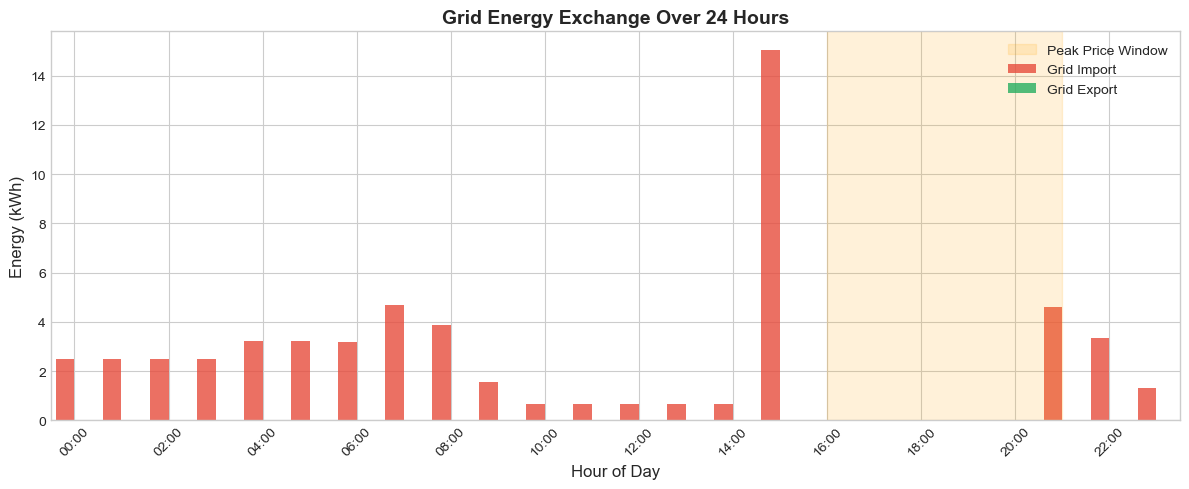

In [3]:
fig, ax = plt.subplots(figsize=(12, 5))

# Create time labels
hours = df_grid['time'].values
hour_labels = [f'{h-1:02d}:00' for h in hours]

# Plot import and export
ax.bar(hours - 0.2, df_grid['import'], width=0.4, label='Grid Import', color='#e74c3c', alpha=0.8)
ax.bar(hours + 0.2, df_grid['export'], width=0.4, label='Grid Export', color='#27ae60', alpha=0.8)

# Add price shading for peak hours (16-21)
ax.axvspan(17, 22, alpha=0.15, color='orange', label='Peak Price Window')

ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Energy (kWh)', fontsize=12)
ax.set_title('Grid Energy Exchange Over 24 Hours', fontsize=14, fontweight='bold')
ax.set_xticks(hours[::2])
ax.set_xticklabels([hour_labels[i] for i in range(0, len(hour_labels), 2)], rotation=45)
ax.legend(loc='upper right')
ax.set_xlim(0.5, 24.5)

plt.tight_layout()
plt.savefig(latest_run / 'plot_grid_exchange.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Water Treatment Flow Over Time

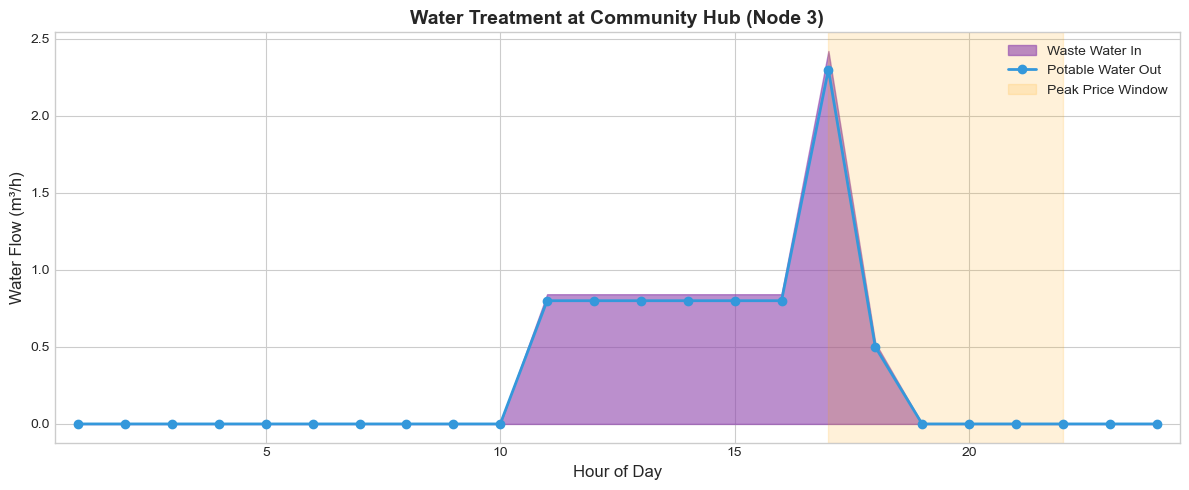

In [4]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.fill_between(df_treatment['time'], df_treatment['waste_in'], 
                alpha=0.6, color='#8e44ad', label='Waste Water In')
ax.plot(df_treatment['time'], df_treatment['potable_out'], 
        'o-', color='#3498db', linewidth=2, markersize=6, label='Potable Water Out')

# Peak price shading
ax.axvspan(17, 22, alpha=0.15, color='orange', label='Peak Price Window')

ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Water Flow (m³/h)', fontsize=12)
ax.set_title('Water Treatment at Community Hub (Node 3)', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.set_xlim(0.5, 24.5)

plt.tight_layout()
plt.savefig(latest_run / 'plot_treatment.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Storage Levels by Node and Layer

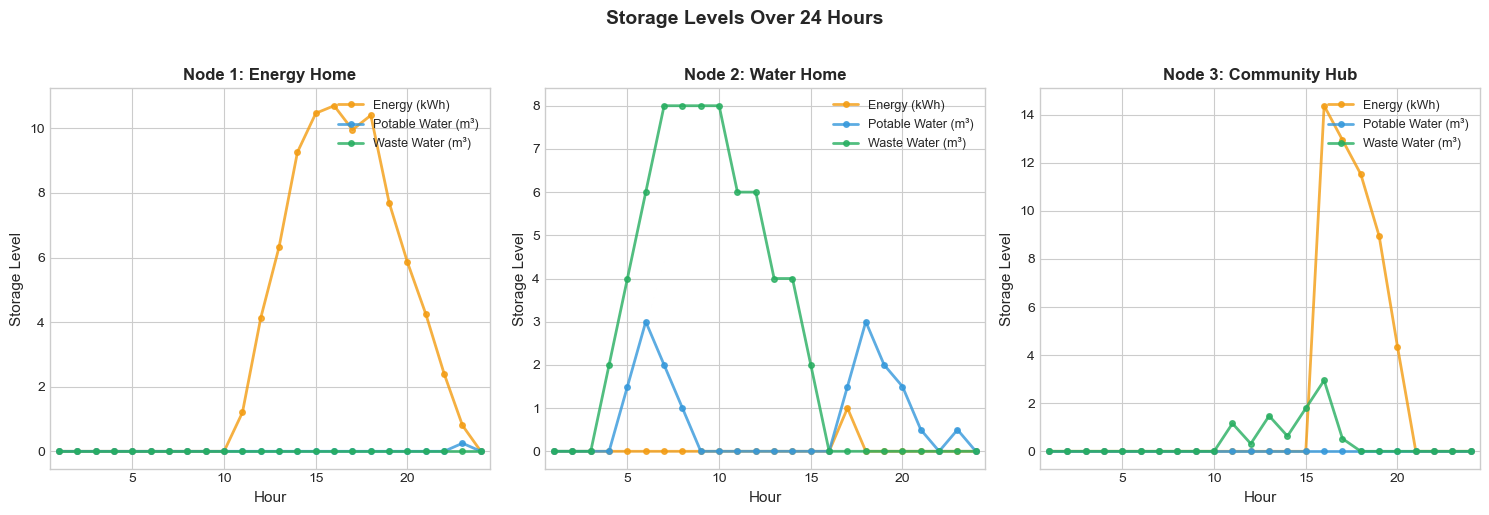

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

layer_colors = {'E': '#f39c12', 'P': '#3498db', 'W': '#27ae60'}
layer_names = {'E': 'Energy (kWh)', 'P': 'Potable Water (m³)', 'W': 'Waste Water (m³)'}
node_names = {1: 'Node 1: Energy Home', 2: 'Node 2: Water Home', 3: 'Node 3: Community Hub'}

for idx, node in enumerate([1, 2, 3]):
    ax = axes[idx]
    node_data = df_storage[df_storage['node'] == node]
    
    for layer in ['E', 'P', 'W']:
        layer_data = node_data[node_data['layer'] == layer]
        ax.plot(layer_data['time'], layer_data['value'], 
                'o-', color=layer_colors[layer], linewidth=2, 
                markersize=4, label=layer_names[layer], alpha=0.8)
    
    ax.set_xlabel('Hour', fontsize=11)
    ax.set_ylabel('Storage Level', fontsize=11)
    ax.set_title(node_names[node], fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.set_xlim(0.5, 24.5)

plt.suptitle('Storage Levels Over 24 Hours', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(latest_run / 'plot_storage.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Flow Heatmap: P2P Transfers

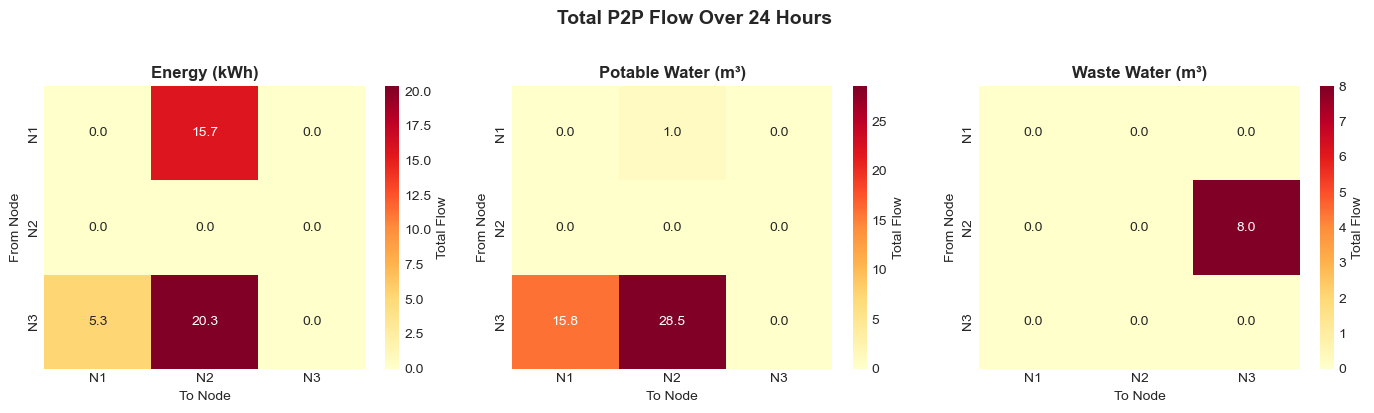

In [6]:
# Aggregate flows over time for each arc and layer
flow_summary = df_flows.groupby(['from', 'to', 'layer'])['value'].sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

nodes = [1, 2, 3]
for idx, layer in enumerate(['E', 'P', 'W']):
    ax = axes[idx]
    
    # Create matrix
    matrix = np.zeros((3, 3))
    layer_flows = flow_summary[flow_summary['layer'] == layer]
    
    for _, row in layer_flows.iterrows():
        if row['from'] in nodes and row['to'] in nodes:
            i = nodes.index(row['from'])
            j = nodes.index(row['to'])
            matrix[i, j] = row['value']
    
    sns.heatmap(matrix, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax,
                xticklabels=['N1', 'N2', 'N3'], yticklabels=['N1', 'N2', 'N3'],
                cbar_kws={'label': 'Total Flow'})
    ax.set_xlabel('To Node')
    ax.set_ylabel('From Node')
    ax.set_title(f'{layer_names[layer]}', fontweight='bold')

plt.suptitle('Total P2P Flow Over 24 Hours', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(latest_run / 'plot_flow_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Energy-Water Nexus: Coupled Operations

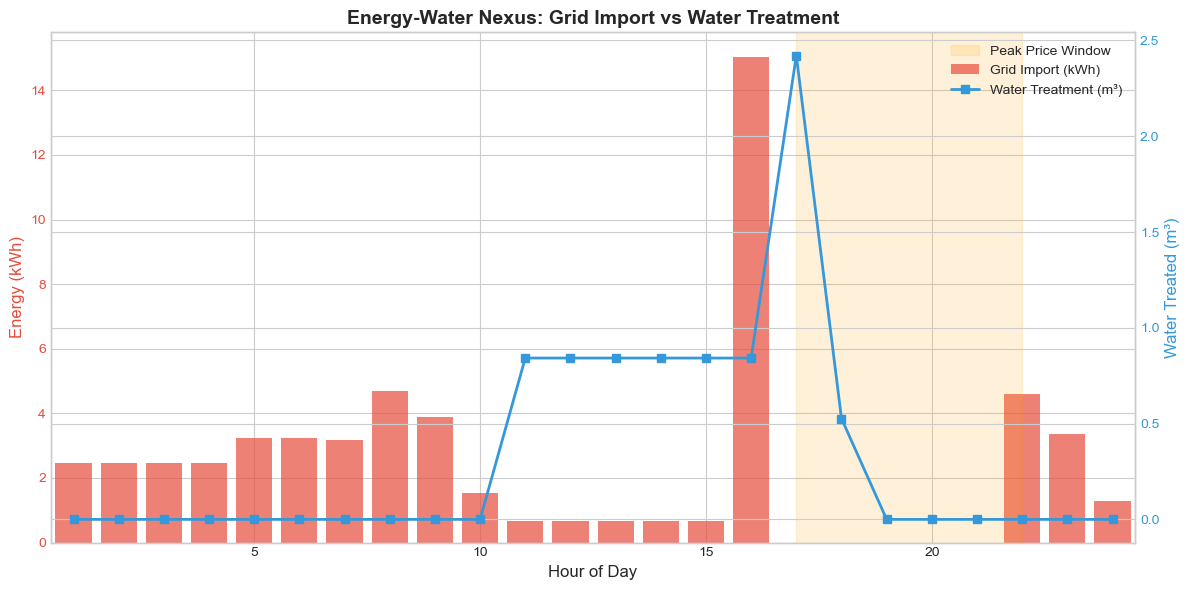

In [7]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Energy from grid
color1 = '#e74c3c'
ax1.bar(df_grid['time'], df_grid['import'], color=color1, alpha=0.7, label='Grid Import (kWh)')
ax1.set_xlabel('Hour of Day', fontsize=12)
ax1.set_ylabel('Energy (kWh)', color=color1, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color1)

# Water treatment on secondary axis
ax2 = ax1.twinx()
color2 = '#3498db'
ax2.plot(df_treatment['time'], df_treatment['waste_in'], 
         's-', color=color2, linewidth=2, markersize=6, label='Water Treatment (m³)')
ax2.set_ylabel('Water Treated (m³)', color=color2, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color2)

# Peak shading
ax1.axvspan(17, 22, alpha=0.15, color='orange', label='Peak Price Window')

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

ax1.set_title('Energy-Water Nexus: Grid Import vs Water Treatment', fontsize=14, fontweight='bold')
ax1.set_xlim(0.5, 24.5)

plt.tight_layout()
plt.savefig(latest_run / 'plot_nexus.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Summary Statistics

In [8]:
print('='*60)
print('OPTIMIZATION RESULTS SUMMARY')
print('='*60)
print(f"\nTotal Operational Cost: ${summary['objective_value']:.2f}")
print(f"\nEnergy:")
print(f"  - Grid Import: {df_grid['import'].sum():.2f} kWh")
print(f"  - Grid Export: {df_grid['export'].sum():.2f} kWh")
print(f"  - Net Grid Usage: {df_grid['import'].sum() - df_grid['export'].sum():.2f} kWh")
print(f"\nWater Treatment:")
print(f"  - Total Waste Treated: {df_treatment['waste_in'].sum():.2f} m³")
print(f"  - Total Potable Produced: {df_treatment['potable_out'].sum():.2f} m³")
print(f"  - Treatment Efficiency: {df_treatment['potable_out'].sum()/df_treatment['waste_in'].sum()*100:.1f}%")
print(f"\nP2P Transfers:")
for layer in ['E', 'P', 'W']:
    total = df_flows[df_flows['layer'] == layer]['value'].sum()
    print(f"  - {layer_names[layer]}: {total:.2f}")
print('='*60)

OPTIMIZATION RESULTS SUMMARY

Total Operational Cost: $85.53

Energy:
  - Grid Import: 57.33 kWh
  - Grid Export: 0.00 kWh
  - Net Grid Usage: 57.33 kWh

Water Treatment:
  - Total Waste Treated: 8.00 m³
  - Total Potable Produced: 7.60 m³
  - Treatment Efficiency: 95.0%

P2P Transfers:
  - Energy (kWh): 41.28
  - Potable Water (m³): 45.25
  - Waste Water (m³): 8.00
